# Проект по ML  3-ий модуль

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tqdm

tqdm.tqdm.pandas()

C:\Users\AMARTUR\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Restaurant_id — идентификационный номер ресторана / сети ресторанов;

City — город, в котором находится ресторан;

Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

Price Range — диапазон цен в ресторане;

Number of Reviews — количество отзывов о ресторане;

Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

URL_TA — URL страницы ресторана на TripAdvisor;

ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_column', 200)

df = pd.read_csv('main_task.csv')

# переименование столбцов для удобства обработки
df.rename(columns={'Restaurant_id':'id',
                    'Cuisine Style':'Style',
                   'Price Range':'PRange',
                  'Number of Reviews':'Numb_Reviews',}, inplace=True
)

# перевод названия столбцов в нижний регистр
df.columns = map(str.lower, df.columns)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            40000 non-null  object 
 1   city          40000 non-null  object 
 2   style         30717 non-null  object 
 3   ranking       40000 non-null  float64
 4   rating        40000 non-null  float64
 5   prange        26114 non-null  object 
 6   numb_reviews  37457 non-null  float64
 7   reviews       40000 non-null  object 
 8   url_ta        40000 non-null  object 
 9   id_ta         40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
df.isnull().sum()

id                  0
city                0
style            9283
ranking             0
rating              0
prange          13886
numb_reviews     2543
reviews             0
url_ta              0
id_ta               0
dtype: int64

Проверка данных на дубли.

Вввиду того, что в столбце Restaurant_id (len(df.index) - df.id.nunique()) значительное количество дублей и само название подсказывает, что id не является индивидуальным номерм исключительно ресторана, для проверки на наличие дублей будет использован столбец "ID_TA".

In [5]:
# количество повторяющихся занчений столбца id
(len(df.index) - df.id.nunique()) 

# удаляем дубликаты в столбце id_ta
df.drop_duplicates('id_ta', inplace=True)

Удаляем id_ta, т.к. для обучения модели он не представляет интереса

In [6]:
# удаляем id_ta, т.к. для обучения модели он не представляет интереса
df.drop(columns=['id_ta', ], inplace=True) #Удаляем id_ta, т.к. для обучения модели он не представляет интереса

## 1. Столбец id (идентификационный номер ресторана / сети ресторанов)

Данная колонка несет информацию о пренадлежности ресторана к той или иной сети. Соответственно это котегориальный признак. Для использования этого  признака в модели, есть необходимость избавиться от приставки и перевести это признак в тип float.

In [7]:
# преобразовал столбец id в формат float
df['id'] = df['id'].apply(lambda x: float(x.replace('id_', ''))) 

In [8]:
# выделяем не сетевые рестораны
from collections import Counter

c = Counter(df['id'])

res = [x for x in df['id'] if c[x] == 1]

len(res)

# если ресторан не сетевой, присваиваем 1, если сетевой - количество ресторанов в сети
df['Rest_in_chain'] = df['id'].apply(lambda x: 1 if x in res else c[x])

display(df.sample(5))


,id,city,style,ranking,rating,prange,numb_reviews,reviews,url_ta,Rest_in_chain
22010,4933.0,Barcelona,['Mediterranean'],4934.0,3.5,$,147.0,"[['Good quality, very cheap buffet', 'A satisf...",/Restaurant_Review-g187497-d2520445-Reviews-Te...,4
1505,2100.0,London,"['Bar', 'British', 'Pub', 'Gastropub']",2104.0,4.0,$,171.0,"[['morning coffee', 'Excellent pub food'], ['1...",/Restaurant_Review-g186338-d731560-Reviews-Red...,6
35462,1623.0,Milan,['Italian'],1625.0,4.0,NaN,106.0,"[[], []]",/Restaurant_Review-g187849-d4104376-Reviews-Un...,7
28275,747.0,Hamburg,"['Middle Eastern', 'Vegetarian Friendly']",748.0,4.0,$$ - $$$,39.0,"[['Interesting and popular restaurant', 'The t...",/Restaurant_Review-g187331-d1039208-Reviews-QA...,10
17778,281.0,Oslo,NaN,282.0,4.5,NaN,12.0,"[['Relaxed', 'Very nice restaurant!'], ['09/24...",/Restaurant_Review-g190479-d12473251-Reviews-G...,11


## 2. Столбец city (город, в котором находится ресторан)

Признак в данной колоне несет котегориальный характер. Для использования его в модели, есть необходимость dummy-признак

## 3. Столбец style (кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане)

Данная переменная носит котегориальный характер. Необходимо также приобразовать ее в dummy-признак.

In [9]:
def style_preprocessing_func(x):
    """
    Функция форматирует строку из такой строки:
    ['European', 'French', 'International']
    Делаем такую:
    European|French|International
    """
    if not pd.isnull(x):
        x = x.replace("'", '').replace('[', '').replace(']', '')
        x = x.split(", ")
        return '|'.join(sorted(x))
    return 'Unknown'

# создаем столбец (на сонове котрого будут заполнятся столбцы-dummy признака)
# создаем множество котрое в последствии станет столбцами и сформирует колонки
df['style_preprocessed'] = df['style'].apply(style_preprocessing_func)
style_names = set(
    '|'.join(df['style_preprocessed'].values)
    .split('|')
)

# создаем пустые столбцы с названиями стилей
for style_name in style_names:
    df[style_name] = 0
    
# заполняем только что созданные столбцы с помощью колонки style_preprocessed или style
def fill_style_dummies(row, style_names):
    for style_name in style_names:
        if style_name in row['style_preprocessed']:
            row[style_name] = 1
    return row

df = df.progress_apply(
    fill_style_dummies,
    axis=1,
    args=(style_names, )
)

style_name

100%|███████████████████████████████████| 39980/39980 [01:49<00:00, 366.62it/s]


'Polynesian'

In [10]:
df['Cuis_Style_in_Rest'] = df['style'].apply(
    lambda x: 1 if pd.isna(x)==True 
    else len(x[1:-1].split(', ')) 
)

## 4. Столбец ranking (место, которое занимает данный ресторан среди всех ресторанов своего города)

Опираясь на здравый смысл, понимаем, что место не может принять отрицательное или нулевое значение.

In [11]:
print('В данном столбце {} незаполненых значений.'.format(df.ranking.isnull().sum()))
print('В данном столбце {} выбросов меньше ноля.'.format(np.sum(df.ranking < 0)))
print('В данном столбце {} выбросов равных нолю.'.format(np.sum(df.ranking ==0)))

В данном столбце 0 незаполненых значений.
В данном столбце 0 выбросов меньше ноля.
В данном столбце 0 выбросов равных нолю.


In [12]:
# находим максимальное значение Ranking для каждого города
df.groupby(['city'])['ranking'].max().sort_values(ascending = False)


city
London        16444.0
Paris         13986.0
Madrid         8809.0
Barcelona      7796.0
Berlin         6372.0
Milan          6275.0
Rome           5946.0
Prague         4188.0
Lisbon         3717.0
Vienna         3444.0
Amsterdam      3249.0
Brussels       3004.0
Munich         2763.0
Hamburg        2736.0
Lyon           2666.0
Stockholm      2464.0
Budapest       2438.0
Warsaw         2141.0
Copenhagen     1964.0
Dublin         1960.0
Athens         1787.0
Edinburgh      1766.0
Zurich         1590.0
Oporto         1484.0
Geneva         1413.0
Krakow         1244.0
Helsinki       1141.0
Oslo           1137.0
Bratislava      889.0
Luxembourg      621.0
Ljubljana       468.0
Name: ranking, dtype: float64

In [14]:
# создаем новый признак "Количество ресторанов в городе" 
df['Rest_in_City'] = ""
df['Rest_in_City'] = df['city'].map({'London':        16444.0,
                                         'Paris':         13986.0,
                                         'Madrid':         8809.0,
                                         'Barcelona':      7796.0,
                                         'Berlin' :        6372.0,
                                         'Milan':          6275.0,
                                         'Rome':           5946.0,
                                         'Prague':         4188.0,
                                         'Lisbon':         3717.0,
                                         'Vienna':         3444.0,
                                         'Amsterdam':      3249.0,
                                         'Brussels':       3004.0,
                                         'Munich':         2763.0,
                                         'Hamburg':        2736.0,
                                         'Lyon':           2666.0,
                                         'Stockholm':      2464.0,
                                         'Budapest':       2438.0,
                                         'Warsaw':         2141.0,
                                         'Copenhagen':     1964.0,
                                         'Dublin':         1960.0,
                                         'Athens':         1787.0,
                                         'Edinburgh':      1766.0,
                                         'Zurich':         1590.0,
                                         'Oporto':         1484.0,
                                         'Geneva':         1413.0,
                                         'Krakow':         1244.0,
                                         'Helsinki':       1141.0,
                                         'Oslo':           1137.0,
                                         'Bratislava':      889.0,
                                         'Luxembourg':      621.0,
                                         'Ljubljana':       468.0}) 

У нас есть количество отзывов о каждом ресторане. Давайте сгруппируем их по городам.

In [15]:
# Сгруппируем колличество отзывов по городам.
df.groupby('city')['numb_reviews'].sum().sort_values(ascending=False)

city
London        746139.0
Rome          583983.0
Paris         561444.0
Milan         352637.0
Barcelona     337566.0
Madrid        289335.0
Prague        159005.0
Lisbon        153705.0
Amsterdam     151909.0
Edinburgh     134393.0
Berlin        129786.0
Budapest      119171.0
Dublin         99463.0
Vienna         89407.0
Brussels       88021.0
Lyon           73148.0
Munich         67301.0
Oporto         64979.0
Stockholm      59075.0
Athens         58039.0
Copenhagen     56498.0
Krakow         50035.0
Warsaw         42169.0
Hamburg        40576.0
Zurich         39167.0
Oslo           34745.0
Geneva         27793.0
Helsinki       21252.0
Luxembourg     16184.0
Bratislava     13697.0
Ljubljana      12646.0
Name: numb_reviews, dtype: float64

In [16]:
# Создаем новый признак "Количество озывов в городе".
df['Reviews_in_City'] = ""
df['Reviews_in_City'] = df['city'].map({'London':     746139,
                                 'Paris':      561444,
                                 'Barcelona':  337566,
                                 'Rome':       583983,
                                 'Madrid':     291655,
                                 'Milan':      352637,
                                 'Berlin':     129786,
                                 'Prague':     159005,
                                 'Amsterdam':  151909,
                                 'Lisbon':     153705,
                                 'Vienna':     89407,
                                 'Budapest':   119171,
                                 'Brussels':   88021,
                                 'Edinburgh':  134393,
                                 'Dublin':     99463,
                                 'Munich':     67301,
                                 'Stockholm':  59075,
                                 'Warsaw':     42169,
                                 'Hamburg':    40576,
                                 'Copenhagen': 56498,
                                 'Athens':     658039,
                                 'Zurich':     39167,
                                 'Lyon':       73148,
                                 'Krakow':     50035,
                                 'Oporto':     64979,
                                 'Geneva':     27793,
                                 'Oslo':       34745,
                                 'Helsinki':   21252,
                                 'Bratislava': 13697,
                                 'Ljubljana':  12646,
                                 'Luxembourg': 16184}) 


In [17]:
df.ranking = np.log(df.ranking)

<AxesSubplot:>

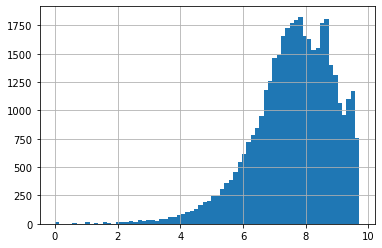

In [18]:
df.ranking.hist(bins=70)

# >>>Целевая переменная<<<

## 5. Столбец rating (рейтинг ресторана по данным TripAdvisor)

Данный признак носит ординальный характер. Судя по гистограмме рейтинг оценивается по 5-ти бальный шкале, выбросов нет

In [13]:
print('В данном колонке {} не заполненых значений.'.format(df.rating.isna().sum()))
print('В данной колонке {} значений меньше ноля.'.format(np.sum(df.rating < 0)))
print('В данной колонке {} значений больше 5-ти.'.format(np.sum(df.rating >5)))

В данном колонке 0 не заполненых значений.
В данной колонке 0 значений меньше ноля.
В данной колонке 0 значений больше 5-ти.


<AxesSubplot:>

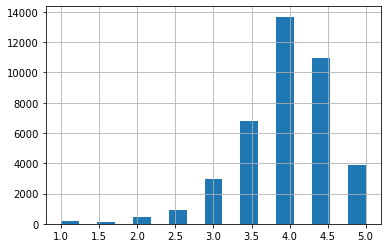

In [135]:
df.rating.hist(bins=17)

## 6 Столбец prange (диапазон цен в ресторане)

В данном признаке имеется большое количество незаполненых значений. Ввиду того, что он будет переведен в dummy-признак, эти пропущенные значения следует заполнить 0 (dummy_na=True).

In [19]:
print('В данном колонке {} не заполненых значений.'.format(df.prange.isna().sum()))

В данном колонке 13879 не заполненых значений.


In [20]:
df.prange.isna().sum()

13879

In [115]:
df.prange.value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: prange, dtype: int64

## 7. Столбец numb_reviews (количество отзывов о ресторане).
Данный признак носит числовой характер и имеет достаточно большой разброс. Наличие большого разброса может говорить как и о том, что персонал ресторана следит за своей целевой аудиторией, устраивает акции, а это означает, что и в целом следить за бизнесом, так и о том, что для увеличения рейтинга отзывы накручиваются. В любом случае, это влияет на целевую переменную. Ввиду очень большого разброса и очень не равномерного распределения, прологарифмирую этот признак.

<AxesSubplot:>

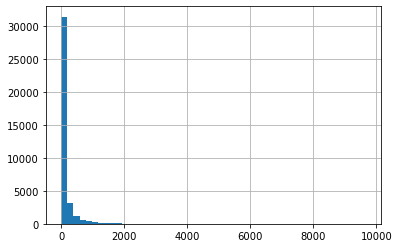

In [21]:
df.numb_reviews.hist(bins=50)

In [142]:
print('В данном столбце {} незаполненых значений.'.format(df.numb_reviews.isnull().sum()))
print('В данном столбце {} выбросов меньше ноля.'.format(np.sum(df.numb_reviews < 0)))
print('В данном столбце {} значений равных нолю.'.format(np.sum(df.numb_reviews ==0)))


В данном столбце 0 незаполненых значений.
В данном столбце 0 выбросов меньше ноля.
В данном столбце 2543 значений равных нолю.


In [22]:
df.numb_reviews = np.log(df.numb_reviews)

<AxesSubplot:>

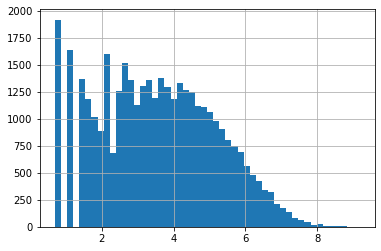

In [23]:
df.numb_reviews.hist(bins=50)

In [24]:
df.numb_reviews = df.numb_reviews.fillna(0)

## 8. Столбец reviews (данные о двух отзывах, которые отображаются на сайте ресторана)

Данный признак неосит тип 'object', не подходит для применения ML.

## 9. Столбец url_ta (URL страницы ресторана на TripAdvisor)

Данный признак имеет тип 'object', для обучения дальнейшей модели не подойдет. По данной колонке можно удостовериться в том, что дубликаты действительно есть. Данный признак в последствии будет удален.

## 10. Столбец id_ta (идентификатор ресторана в базе данных TripAdvisor)

По данному признаку произведен поиск дубликатов, т.к. он носит индивидуальный характер в отлича от признака id. После он был удален, ввиду того, что больше не представлял интереса.

## Корреляционная признаков

<AxesSubplot:>

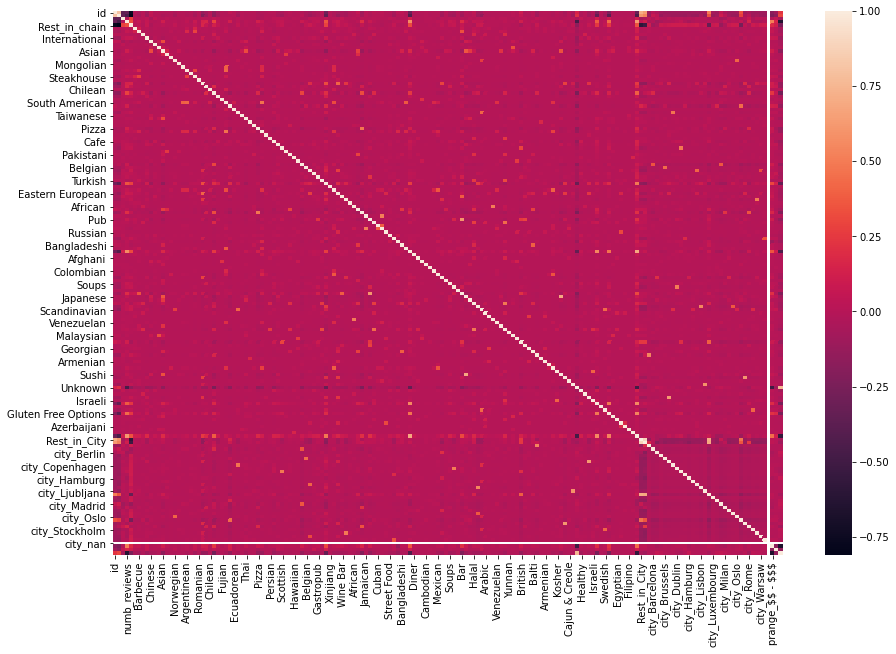

In [40]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr(),)

 ## Финальное удаление признаков
 
 После преобразований даные признаки стоит удалить

In [25]:
df.drop(
    columns=[
        'style', 'style_preprocessed', 'reviews', 'url_ta',
    ], inplace=True)

## Преобразование признаков в dummy-переменые

In [26]:
df = pd.get_dummies(df, columns=['city', 'prange'], 
                    drop_first=True, dummy_na=True
)

In [27]:
df.shape

(39980, 168)

In [28]:
df.isna().sum()

id                     0
ranking                0
rating                 0
numb_reviews           0
Rest_in_chain          0
Grill                  0
Barbecue               0
Moroccan               0
International          0
Chinese                0
Delicatessen           0
Singaporean            0
Asian                  0
Nepali                 0
Southwestern           0
Norwegian              0
Mongolian              0
Peruvian               0
Argentinean            0
Albanian               0
Steakhouse             0
Romanian               0
Central European       0
Seafood                0
Chilean                0
Mediterranean          0
Dutch                  0
Fujian                 0
South American         0
French                 0
Ecuadorean             0
Danish                 0
Taiwanese              0
Thai                   0
Australian             0
Native American        0
Pizza                  0
American               0
Latvian                0
Persian                0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [29]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['id', 'rating'], axis = 1)
y = df['rating']

In [30]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [31]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [32]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [36]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [37]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21159329664832416
